[https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb)

In [1]:
import os
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib

# Get all the files

In [3]:
data_dir = 'data'
img_dir = os.path.join(data_dir, "train")
label_dir = os.path.join(data_dir, "train_masks")

In [4]:
df_train = pd.read_csv(os.path.join(data_dir, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [5]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [6]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [7]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


### Here's what the paths look like

In [8]:
x_train_filenames[:10]

['data/train/69915dab0755_16.jpg',
 'data/train/695f39dfac16_04.jpg',
 'data/train/2267f4aa0d2c_13.jpg',
 'data/train/562706000bd7_15.jpg',
 'data/train/917f262f1608_06.jpg',
 'data/train/fce0ba5b8ed7_07.jpg',
 'data/train/93881caf9f70_10.jpg',
 'data/train/eb07e3f63ad2_09.jpg',
 'data/train/78bfb9c780db_10.jpg',
 'data/train/d3d0d2662918_12.jpg']

In [9]:
y_train_filenames[:10]

['data/train_masks/69915dab0755_16_mask.gif',
 'data/train_masks/695f39dfac16_04_mask.gif',
 'data/train_masks/2267f4aa0d2c_13_mask.gif',
 'data/train_masks/562706000bd7_15_mask.gif',
 'data/train_masks/917f262f1608_06_mask.gif',
 'data/train_masks/fce0ba5b8ed7_07_mask.gif',
 'data/train_masks/93881caf9f70_10_mask.gif',
 'data/train_masks/eb07e3f63ad2_09_mask.gif',
 'data/train_masks/78bfb9c780db_10_mask.gif',
 'data/train_masks/d3d0d2662918_12_mask.gif']

# Set up
Let’s begin by setting up some parameters. We’ll standardize and resize all the shapes of the images. We’ll also set up some training parameters:

In [10]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 5

Using these exact same parameters may be too computationally intensive for your hardware, so tweak the parameters accordingly. Also, it is important to note that due to the architecture of our UNet version, the size of the image must be evenly divisible by a factor of 32, as we down sample the spatial resolution by a factor of 2 with each MaxPooling2Dlayer.

If your machine can support it, you will achieve better performance using a higher resolution input image (e.g. 512 by 512) as this will allow more precise localization and less loss of information during encoding. In addition, you can also make the model deeper.

Alternatively, if your machine cannot support it, lower the image resolution and/or batch size. Note that lowering the image resolution will decrease performance and lowering batch size will increase training time.

# Build our input pipeline with `tf.data`
Since we begin with filenames, we will need to build a robust and scalable data pipeline that will play nicely with our model. If you are unfamiliar with **tf.data** you should check out my other tutorial introducing the concept! 

### Our input pipeline will consist of the following steps:
1. Read the bytes of the file in from the filename - for both the image and the label. Recall that our labels are actually images with each pixel annotated as car or background (1, 0). 
2. Decode the bytes into an image format
3. Apply image transformations: (optional, according to input parameters)
  * `resize` - Resize our images to a standard size (as determined by eda or computation/memory restrictions)
    * The reason why this is optional is that U-Net is a fully convolutional network (e.g. with no fully connected units) and is thus not dependent on the input size. However, if you choose to not resize the images, you must use a batch size of 1, since you cannot batch variable image size together
    * Alternatively, you could also bucket your images together and resize them per mini-batch to avoid resizing images as much, as resizing may affect your performance through interpolation, etc.
  * `hue_delta` - Adjusts the hue of an RGB image by a random factor. This is only applied to the actual image (not our label image). The `hue_delta` must be in the interval `[0, 0.5]` 
  * `horizontal_flip` - flip the image horizontally along the central axis with a 0.5 probability. This transformation must be applied to both the label and the actual image. 
  * `width_shift_range` and `height_shift_range` are ranges (as a fraction of total width or height) within which to randomly translate the image either horizontally or vertically. This transformation must be applied to both the label and the actual image. 
  * `rescale` - rescale the image by a certain factor, e.g. 1/ 255.
4. Shuffle the data, repeat the data (so we can iterate over it multiple times across epochs), batch the data, then prefetch a batch (for efficiency).

It is important to note that these transformations that occur in your data pipeline must be symbolic transformations. 

#### Why do we do these image transformations?
This is known as **data augmentation**. Data augmentation "increases" the amount of training data by augmenting them via a number of random transformations. During training time, our model would never see twice the exact same picture. This helps prevent [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) and helps the model generalize better to unseen data.

## Processing each pathname

In [11]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair  
    img_str = tf.read_file(fname)
    img = tf.image.decode_jpeg(img_str, channels=3)

    label_img_str = tf.read_file(label_path)
    # These are gif images so they return as (num_frames, h, w, c)
    label_img = tf.image.decode_gif(label_img_str)[0]
    # The label image should only have values of 1 or 0, indicating pixel wise
    # object (car) or not (background). We take the first channel only. 
    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    return img, label_img

## Shifting the image

In [12]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
        # Translate both 
        output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
        label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
    return output_img, label_img

## Flipping the image randomly 

In [13]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

## Assembling our transformations into our augment function

In [14]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize_images(label_img, resize)
        img = tf.image.resize_images(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.to_float(label_img) * scale
    img = tf.to_float(img) * scale 
    return img, label_img

In [15]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
    if shuffle:
        dataset = dataset.shuffle(num_x)
  
  
    # It's necessary to repeat our data for all epochs and then prefetch a batch (for efficiency).
    dataset = dataset.repeat().batch(batch_size).prefetch(1)
    return dataset

## Set up train and validation datasets
Note that we apply image augmentation to our training dataset but not our validation dataset. 

In [16]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [17]:
val_cfg = {
            'resize': [img_shape[0], img_shape[1]],
            'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [18]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

## Let's see if our image augmentor data pipeline is producing expected results

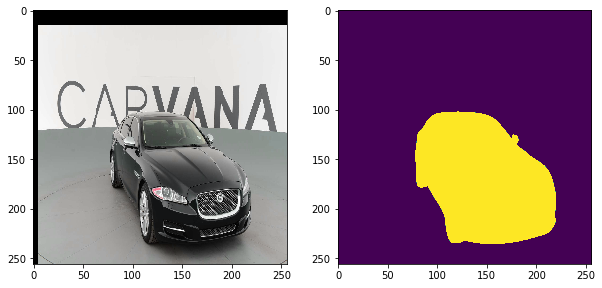

In [19]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
    batch_of_imgs, label = sess.run(next_element)

    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = batch_of_imgs[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(label[0, :, :, 0])
    plt.show()